# The Photovoltaic Revolution

With climate change remaining a prevalent concern amongst many Americans for the foreseeable future, there has been some debate about how to approach the issue. Some consider the failure to act now a proverbial nail in the coffin, while others are optimistic that the rate of technological change will eventually help sort out this problem. William Nordhaus, who has been referred to as the leading mind in the economics of climate change, addresses the issue as a matter of careful cost-benefit consideration. In his book, The Climate Casino: Risk, Uncertainty, and Economics for a Warming World, he describes some of the nuanced and unknown issues pertaining to the economics of action against climate change and even puts into question some of the methods largely considered a best course of action.

Photovoltaic panels, or solar panels, are one of these aforementioned methods that, although has been proven to be efficient in some scenarios, is not a feasible first choice for clean electricity production on a massive scale. However, solar panels can supplement the net electricity consumption and many solar advocates claim that solar panels can decrease the price of electricity, not just for your own home or place of business, but for your neighbors as well. This has been the primary incentive for implementing solar panels into communities, however, we’d like to see if we can predict the use of solar panels in a given region, possibly to get some insight into characteristics that are associated with solar adoption. Although there are many incentives in place to increase public support and adoption of solar panels, there seems to be stagnation in the adoption rate of residential community-wide solar integration. We’ll attempt to predict the adoption of solar panels across the US using various machine learning algorithms.

Stanford's DeepSolar project used satelite imaging and computer vision to identify solar panels within the continental United States. Rather than undertaking a project to image the entire U.S., is there a way to predict the adoption of photovoltaic panels across the U.S. using demographic, economic, and geospatial data. The data can be found on the DeepSolar website: http://web.stanford.edu/group/deepsolar/home. 


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

In [54]:
def plot_ann_auc(model,X_test,y_test,model_name='model_name'):
    n_probs = [0 for _ in range(len(y_test))]
    x_probs = model.predict_proba(X_test)
    x_probs = x_probs[:,0]
    n_auc = roc_auc_score(y_test, n_probs)
    x_auc = roc_auc_score(y_test, x_probs)

    print('No Skill Rate AUC: ',n_auc)
    print('Learned AUC: ',x_auc)

    n_fpr, n_tpr, _ = roc_curve(y_test,n_probs)
    l_fpr, l_tpr, _ = roc_curve(y_test,x_probs)

    plt.figure(figsize=(16,8))
    plt.plot(n_fpr,n_tpr,linestyle='--',label='No skill rate')
    plt.plot(l_fpr,l_tpr,marker='.',label=model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

In [68]:
def plot_prob_auc(model,X_test,y_test,model_name='model_name'):
    n_probs = [0 for _ in range(len(y_test))]
    x_probs = model.predict_proba(X_test)
    x_probs = x_probs[:, 1]
    n_auc = roc_auc_score(y_test, n_probs)
    x_auc = roc_auc_score(y_test, x_probs)

    print('No Skill Rate AUC: ',n_auc)
    print('Learned AUC: ',x_auc)

    n_fpr, n_tpr, _ = roc_curve(y_test,n_probs)
    l_fpr, l_tpr, _ = roc_curve(y_test,x_probs)

    plt.figure(figsize=(16,8))
    plt.plot(n_fpr,n_tpr,linestyle='--',label='No skill rate')
    plt.plot(l_fpr,l_tpr,marker='.',label=model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

In [2]:
data = pd.read_csv('deepsolar_tract.csv', delimiter=',',encoding='latin-1')

In [3]:
use_cols = ['tile_count','average_household_income','county','education_bachelor','education_college',
            'education_doctoral','education_high_school_graduate','education_less_than_high_school',
            'education_master','education_population','education_professional_school','land_area',
            'per_capita_income','population','population_density','poverty_family_below_poverty_level',
            'poverty_family_count','state','total_area','unemployed','water_area','employ_rate',
            'poverty_family_below_poverty_level_rate','median_household_income','electricity_price_residential',
            'electricity_price_commercial','electricity_price_industrial','electricity_price_transportation',
            'electricity_price_overall','electricity_consume_residential','electricity_consume_commercial',
            'electricity_consume_industrial','electricity_consume_total','household_count','average_household_size',
            'housing_unit_count','housing_unit_occupied_count','housing_unit_median_value',
            'housing_unit_median_gross_rent','heating_design_temperature',
            'cooling_design_temperature','earth_temperature_amplitude','frost_days','air_temperature',
            'relative_humidity','daily_solar_radiation','atmospheric_pressure','wind_speed','earth_temperature',
            'heating_degree_days','cooling_degree_days','age_18_24_rate','age_25_34_rate','age_more_than_85_rate',
            'age_75_84_rate','age_35_44_rate','age_45_54_rate','age_65_74_rate','age_55_64_rate','age_10_14_rate',
            'age_15_17_rate','age_5_9_rate','household_type_family_rate','dropout_16_19_inschool_rate',
            'occupation_construction_rate','occupation_public_rate','occupation_information_rate',
            'occupation_finance_rate','occupation_education_rate','occupation_administrative_rate',
            'occupation_manufacturing_rate','occupation_wholesale_rate','occupation_retail_rate',
            'occupation_transportation_rate','occupation_arts_rate','occupation_agriculture_rate',
            'occupancy_vacant_rate','occupancy_owner_rate','mortgage_with_rate','transportation_home_rate',
            'transportation_car_alone_rate','transportation_walk_rate','transportation_carpool_rate',
            'transportation_motorcycle_rate','transportation_bicycle_rate','transportation_public_rate',
            'travel_time_less_than_10_rate','travel_time_10_19_rate','travel_time_20_29_rate',
            'travel_time_30_39_rate','travel_time_40_59_rate','travel_time_60_89_rate','health_insurance_public_rate',
            'health_insurance_none_rate','age_median','travel_time_average','voting_2016_dem_percentage',
            'voting_2016_gop_percentage','voting_2012_dem_percentage','voting_2012_gop_percentage',
            'number_of_years_of_education','diversity','incentive_count_residential',
            'incentive_count_nonresidential','incentive_residential_state_level','incentive_nonresidential_state_level',
            'net_metering','feedin_tariff','cooperate_tax','property_tax','sales_tax','rebate','avg_electricity_retail_rate']

## Dropped Features
The following features were dropped due to the redundancy, direct inference to the predicted variable or it's not necessary for domain understanding.

In [4]:
dropped = [col for col in data.columns if col not in use_cols]
np.array(dropped).flatten()

array(['Unnamed: 0', 'solar_system_count', 'total_panel_area', 'fips',
       'employed', 'gini_index', 'heating_fuel_coal_coke',
       'heating_fuel_electricity', 'heating_fuel_fuel_oil_kerosene',
       'heating_fuel_gas', 'heating_fuel_housing_unit_count',
       'heating_fuel_none', 'heating_fuel_other', 'heating_fuel_solar',
       'race_asian', 'race_black_africa', 'race_indian_alaska',
       'race_islander', 'race_other', 'race_two_more', 'race_white',
       'education_less_than_high_school_rate',
       'education_high_school_graduate_rate', 'education_college_rate',
       'education_bachelor_rate', 'education_master_rate',
       'education_professional_school_rate', 'education_doctoral_rate',
       'race_white_rate', 'race_black_africa_rate',
       'race_indian_alaska_rate', 'race_asian_rate', 'race_islander_rate',
       'race_other_rate', 'race_two_more_rate', 'heating_fuel_gas_rate',
       'heating_fuel_electricity_rate',
       'heating_fuel_fuel_oil_kerosene_rate'

In [5]:
df = data[use_cols]

In [6]:
df.tile_count.describe()

count    72537.000000
mean        30.255787
std         86.337406
min          0.000000
25%          1.000000
50%          4.000000
75%         22.000000
max       4468.000000
Name: tile_count, dtype: float64

In [7]:
df.loc[df.tile_count == 0,'adoption'] = 0.0
df.loc[(df.tile_count>0),'adoption'] = 1

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\patrick\anaconda3\envs\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
df.adoption.value_counts()

1.0    56258
0.0    16279
Name: adoption, dtype: int64

In [9]:
df.state = df.state.str.upper()

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
state_df = df.groupby('state').sum()

In [11]:
fig = px.choropleth(locations=state_df.index, locationmode="USA-states", color=state_df.tile_count, scope="usa")
fig.show()

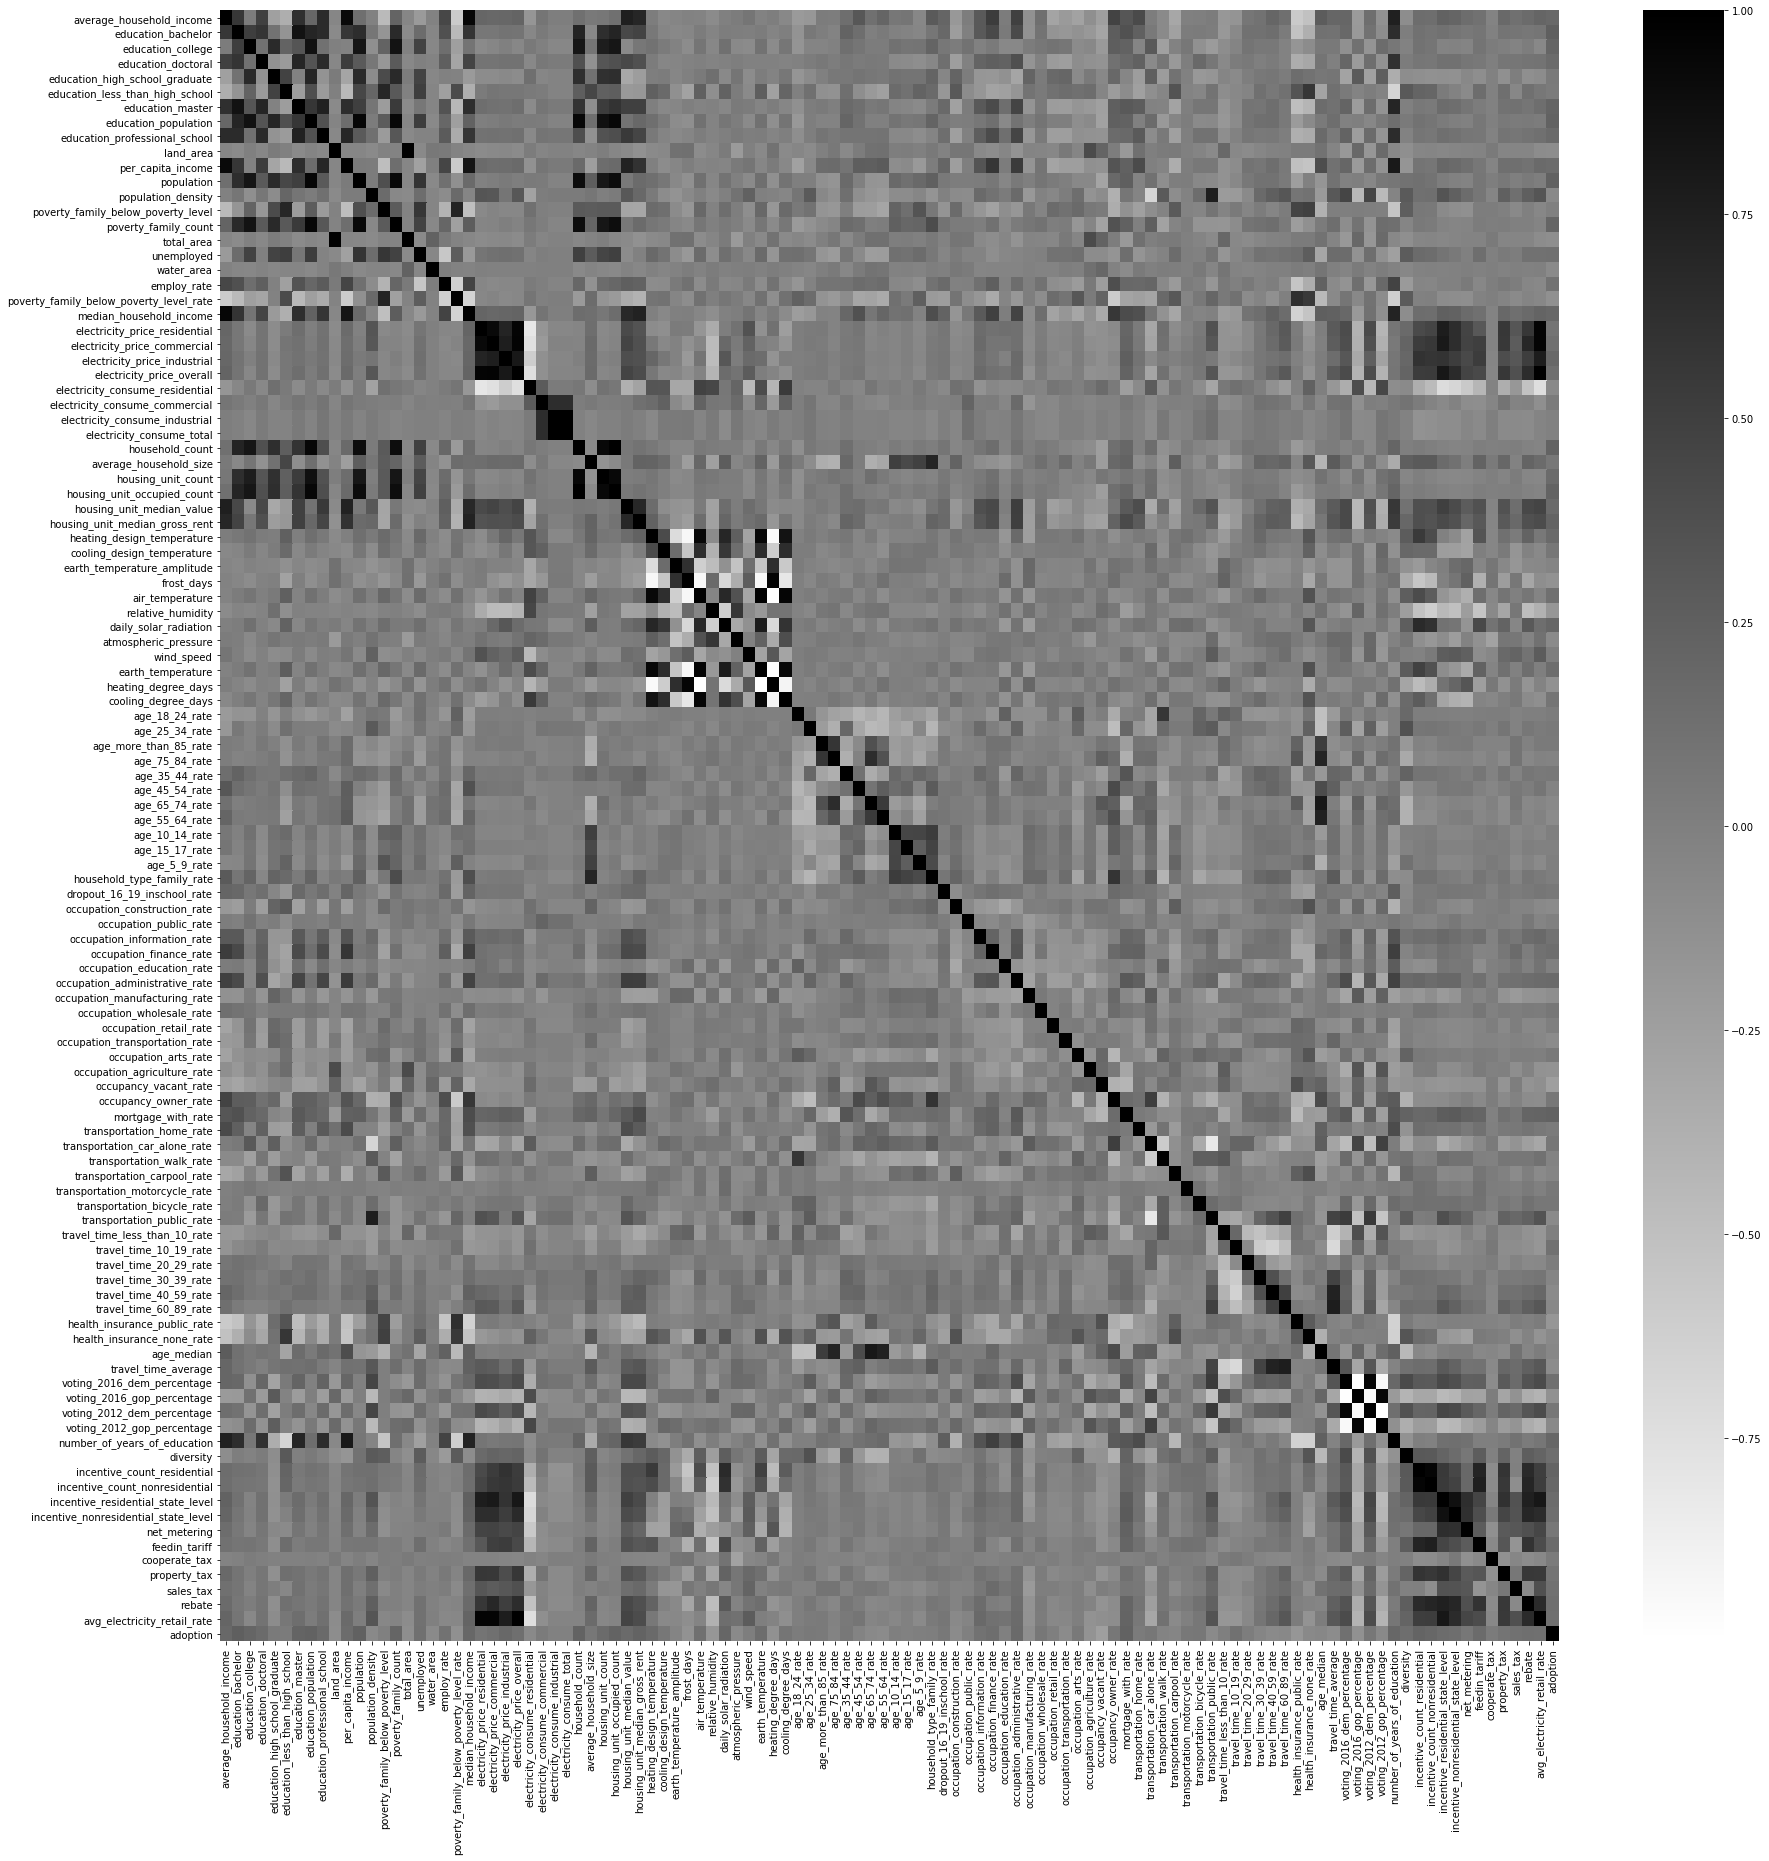

In [12]:
corr = df.drop(['tile_count','county','state'],axis=1).corr()
plt.figure(figsize=(30,30))
fig = sns.heatmap(data=corr,cmap='binary')

In [56]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit

In [15]:
encoder = LabelEncoder()
df['county_code'] = encoder.fit_transform(df.county)
df['state_code'] = encoder.fit_transform(df.state)
df.loc[df.electricity_price_transportation==df.electricity_price_transportation.value_counts().index[0],'electricity_price_transportation'] = 0
df.electricity_price_transportation = df.electricity_price_transportation.astype(float)

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [16]:
[col for col in df.columns if df[col].dtype=='O']

['county', 'state']

In [17]:
df.shape

(72537, 116)

In [18]:
state_meds = df.groupby('state').median()
for col in state_meds.columns:
    print(col,' : ',round((state_meds[col].isna().sum()/72537)*100,2),'%')

tile_count  :  0.0 %
average_household_income  :  0.0 %
education_bachelor  :  0.0 %
education_college  :  0.0 %
education_doctoral  :  0.0 %
education_high_school_graduate  :  0.0 %
education_less_than_high_school  :  0.0 %
education_master  :  0.0 %
education_population  :  0.0 %
education_professional_school  :  0.0 %
land_area  :  0.0 %
per_capita_income  :  0.0 %
population  :  0.0 %
population_density  :  0.0 %
poverty_family_below_poverty_level  :  0.0 %
poverty_family_count  :  0.0 %
total_area  :  0.0 %
unemployed  :  0.0 %
water_area  :  0.0 %
employ_rate  :  0.0 %
poverty_family_below_poverty_level_rate  :  0.0 %
median_household_income  :  0.0 %
electricity_price_residential  :  0.0 %
electricity_price_commercial  :  0.0 %
electricity_price_industrial  :  0.0 %
electricity_price_transportation  :  0.0 %
electricity_price_overall  :  0.0 %
electricity_consume_residential  :  0.0 %
electricity_consume_commercial  :  0.0 %
electricity_consume_industrial  :  0.0 %
electricity_c

In [19]:
county_meds = df.groupby('county').median()
for col in county_meds.columns:
    print(col,' : ',round((county_meds[col].isna().sum()/72537)*100,2),'%')

tile_count  :  0.0 %
average_household_income  :  0.0 %
education_bachelor  :  0.0 %
education_college  :  0.0 %
education_doctoral  :  0.0 %
education_high_school_graduate  :  0.0 %
education_less_than_high_school  :  0.0 %
education_master  :  0.0 %
education_population  :  0.0 %
education_professional_school  :  0.0 %
land_area  :  0.0 %
per_capita_income  :  0.0 %
population  :  0.0 %
population_density  :  0.0 %
poverty_family_below_poverty_level  :  0.0 %
poverty_family_count  :  0.0 %
total_area  :  0.0 %
unemployed  :  0.0 %
water_area  :  0.0 %
employ_rate  :  0.0 %
poverty_family_below_poverty_level_rate  :  0.0 %
median_household_income  :  0.0 %
electricity_price_residential  :  0.0 %
electricity_price_commercial  :  0.0 %
electricity_price_industrial  :  0.0 %
electricity_price_transportation  :  0.0 %
electricity_price_overall  :  0.0 %
electricity_consume_residential  :  0.0 %
electricity_consume_commercial  :  0.0 %
electricity_consume_industrial  :  0.0 %
electricity_c

In [20]:
county_impute = ['average_household_income','land_area','per_capita_income','population_density',
                 'total_area','water_area','employ_rate','poverty_family_below_poverty_level_rate',
                 'median_household_income','average_household_size','housing_unit_median_value',
                 'housing_unit_median_gross_rent','age_18_24_rate','age_25_34_rate','age_more_than_85_rate',
                 'age_75_84_rate','age_35_44_rate','age_45_54_rate','age_65_74_rate','age_55_64_rate','age_10_14_rate',
                 'age_15_17_rate','age_5_9_rate','household_type_family_rate','dropout_16_19_inschool_rate',
                 'occupation_construction_rate','occupation_public_rate','occupation_information_rate','occupation_finance_rate',
                 'occupation_education_rate','occupation_administrative_rate','occupation_manufacturing_rate',
                 'occupation_wholesale_rate','occupation_retail_rate','occupation_transportation_rate','occupation_arts_rate',
                 'occupation_agriculture_rate','occupancy_vacant_rate','occupancy_owner_rate','mortgage_with_rate',
                 'transportation_home_rate','transportation_car_alone_rate','transportation_walk_rate','transportation_carpool_rate',
                 'transportation_motorcycle_rate','transportation_bicycle_rate','transportation_public_rate',
                 'travel_time_less_than_10_rate','travel_time_10_19_rate','travel_time_20_29_rate','travel_time_30_39_rate',
                 'travel_time_40_59_rate','travel_time_60_89_rate','health_insurance_public_rate','health_insurance_none_rate',
                 'age_median','travel_time_average','voting_2012_dem_percentage','voting_2012_gop_percentage',
                 'number_of_years_of_education','diversity']

state_impute = ['heating_design_temperature','cooling_design_temperature',
                'earth_temperature_amplitude','frost_days','air_temperature','relative_humidity',
                'daily_solar_radiation','atmospheric_pressure','wind_speed','earth_temperature',
                'heating_degree_days','cooling_degree_days','voting_2012_dem_percentage','voting_2012_gop_percentage']



In [21]:
for col in county_impute:
    df[col] = df.groupby('county')[col].transform(lambda x: x.fillna(x.median()))
    
for col in state_impute:
    df[col] = df.groupby('state')[col].transform(lambda x: x.fillna(x.median()))

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning:

Mean of empty slice

c:\users\patrick\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df.loc[df.voting_2012_dem_percentage.isnull(),'voting_2012_dem_percentage'] = df.voting_2012_dem_percentage.median()
df.loc[df.voting_2012_gop_percentage.isnull(),'voting_2012_gop_percentage'] = df.voting_2012_gop_percentage.median()

In [24]:
for col in df.columns:
    print(col,' : ',round((df[col].isna().sum()/72537)*100,2),'%')

tile_count  :  0.0 %
average_household_income  :  0.0 %
county  :  0.0 %
education_bachelor  :  0.0 %
education_college  :  0.0 %
education_doctoral  :  0.0 %
education_high_school_graduate  :  0.0 %
education_less_than_high_school  :  0.0 %
education_master  :  0.0 %
education_population  :  0.0 %
education_professional_school  :  0.0 %
land_area  :  0.0 %
per_capita_income  :  0.0 %
population  :  0.0 %
population_density  :  0.0 %
poverty_family_below_poverty_level  :  0.0 %
poverty_family_count  :  0.0 %
state  :  0.0 %
total_area  :  0.0 %
unemployed  :  0.0 %
water_area  :  0.0 %
employ_rate  :  0.0 %
poverty_family_below_poverty_level_rate  :  0.0 %
median_household_income  :  0.0 %
electricity_price_residential  :  0.0 %
electricity_price_commercial  :  0.0 %
electricity_price_industrial  :  0.0 %
electricity_price_transportation  :  0.0 %
electricity_price_overall  :  0.0 %
electricity_consume_residential  :  0.0 %
electricity_consume_commercial  :  0.0 %
electricity_consume_i

In [25]:
df = df.dropna()

In [26]:
X = df.drop(['tile_count','adoption','county','state'],axis=1)
y = df['adoption']
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3)

In [28]:
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

In [29]:
scaled_data['adoption'] = df['adoption']

In [30]:
scaled_data = scaled_data.dropna()

In [31]:
X_scaled = scaled_data.drop('adoption',axis=1)
y_scaled = scaled_data['adoption']
X_trains, X_tests, y_trains, y_tests = train_test_split(X_scaled, y_scaled, random_state=42, test_size=0.3)

# Random Forest

Althought gradient boosting will perform better, the algorithms is extremely computationally expensive, so for the sake of this analysis, we'll use a Random Forest. The great thing about a Random Forests are their ability to arrive at interpretable conclusions. Through viewing which features ultimately lead to the highest information gain across the estimators, we can see the features which provide the highest information gain across the forest of decision trees. Intuitively, we can observe the feature importance as a proxy to the real life predictive power of each attribute associated with the classification of solar adoption.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [186]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [187]:
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.45      0.55      4892
         1.0       0.86      0.94      0.90     16867

    accuracy                           0.83     21759
   macro avg       0.78      0.70      0.72     21759
weighted avg       0.82      0.83      0.82     21759



In [ ]:
rf_auc = GridSearchCV(rf,param_grid={'n_estimators':np.arange(80,240,20),
                                     'criterion':['gini','entropy'],
                                     'max_depth':[5,10,20,25,30,50,100],
                                     'min_samples_split':[2,5,10,50,250,500]},
                      scoring='roc_auc',
                      cv=5,
                      n_jobs=-1)
rf_auc.fit(X_train,y_train)

## Parameter Tuning

I've elected to tune the model with the cross validated grid search that yeilds the highest ROC Area Under the Curve. Since more of the United States has adopted solar than not, either F1-score or the AUC are better to use, as to avoid the class imbalance driven misguidance of relying in accuracy as a measurement of model performance. Roughly 77% of counties (fips identifiaction regions) have adopted PV as part of the energy infrastructure at some scale. We'd like to avoid developing a model that evolves into a simple majority vote classifier, so accuracy is not an ideal indicator for our use case.

In [33]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_depth=25,
                                criterion='entropy',
                                min_samples_split=10,
                                random_state=42,
                                n_jobs=-1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Random Forest Performance Evaluation

The tuned Random Forest performs well in predicting the adoption of solar panel generation across the U.S. Depending on the use case scenario of this data, we may want to tune for optimizing different metrics. For instance, this model performs better on the majority class: counties with solar, and not as well on the minority class. Considering the metrics seen below, rather than further tuning, we may want to resort to some resampling methods or dimensionality reduction in the future.

In [34]:
rfclf_pred = rf_clf.predict(X_test)
print(classification_report(y_test,rfclf_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.44      0.54      4892
         1.0       0.85      0.95      0.90     16867

    accuracy                           0.83     21759
   macro avg       0.78      0.69      0.72     21759
weighted avg       0.82      0.83      0.82     21759



No Skill Rate AUC:  0.5
Learned AUC:  0.8746644604139518


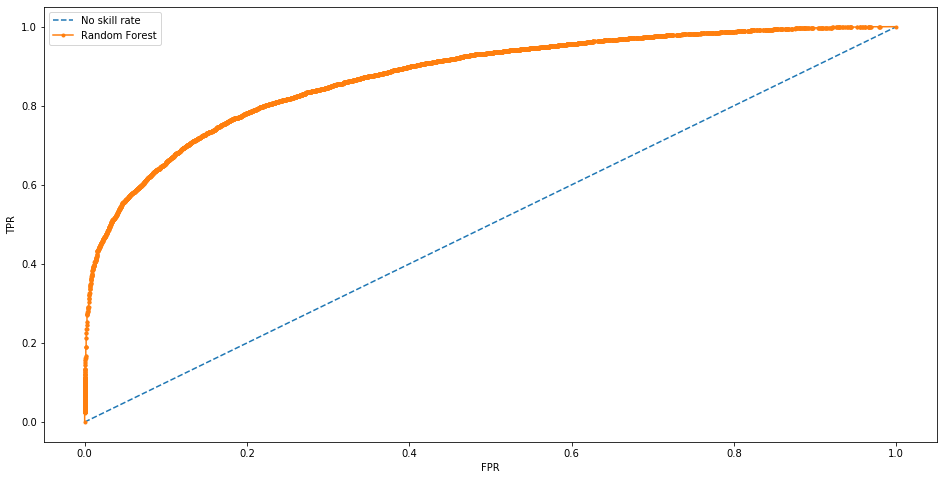

In [69]:
plot_prob_auc(rf_clf,X_test,y_test,model_name='Random Forest')

# Artificial Neural Network

We can see below the construction of a perceptron using the sigomid function at the output layer and relu at the input layer. Using the Nesterov momentum algorithm with the Adam gradient optimization algorithm, or Nadam for short. We can see the accuracy and auc after each epoch and notice that we have an early stopping criteria as well as the use of binary crossentropy as our loss function to measure for backpropogation weight and bias updates.

In [197]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

In [233]:
perc = Sequential()
perc.add(Dense(112,
               input_dim=112,
               activation='relu',
               kernel_initializer=initializers.glorot_uniform(seed=42),
               bias_initializer='zeros'))
perc.add(Dense(1,
               input_dim=112,
               activation='sigmoid',
               kernel_initializer=initializers.glorot_uniform(seed=42),
               bias_initializer='zeros'))

In [234]:
earlystop_callback = EarlyStopping(monitor='accuracy',
                                   min_delta=0.0001,
                                   patience=7)

In [235]:
auc = AUC()

In [236]:
perc.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['accuracy',auc])
perc.fit(X_trains.values,y_trains.values,epochs=100,callbacks=[earlystop_callback])

Train on 50766 samples
Epoch 1/100
50766/50766 [==============================] - 2s 40us/sample - loss: 0.4367 - accuracy: 0.7918 - auc_9: 0.7869
Epoch 2/100
50766/50766 [==============================] - 1s 29us/sample - loss: 0.4186 - accuracy: 0.7994 - auc_9: 0.8101
Epoch 3/100
50766/50766 [==============================] - 1s 29us/sample - loss: 0.4126 - accuracy: 0.8033 - auc_9: 0.8166
Epoch 4/100
50766/50766 [==============================] - 1s 29us/sample - loss: 0.4087 - accuracy: 0.8045 - auc_9: 0.8209
Epoch 5/100
50766/50766 [==============================] - 2s 31us/sample - loss: 0.4051 - accuracy: 0.8067 - auc_9: 0.8249
Epoch 6/100
50766/50766 [==============================] - 2s 30us/sample - loss: 0.4028 - accuracy: 0.8072 - auc_9: 0.8274
Epoch 7/100
50766/50766 [==============================] - 1s 29us/sample - loss: 0.3997 - accuracy: 0.8095 - auc_9: 0.8306
Epoch 8/100
50766/50766 [==============================] - 1s 29us/sample - loss: 0.3978 - accuracy: 0.8100 -

No Skill Rate AUC:  0.5
Learned AUC:  0.828785782575694


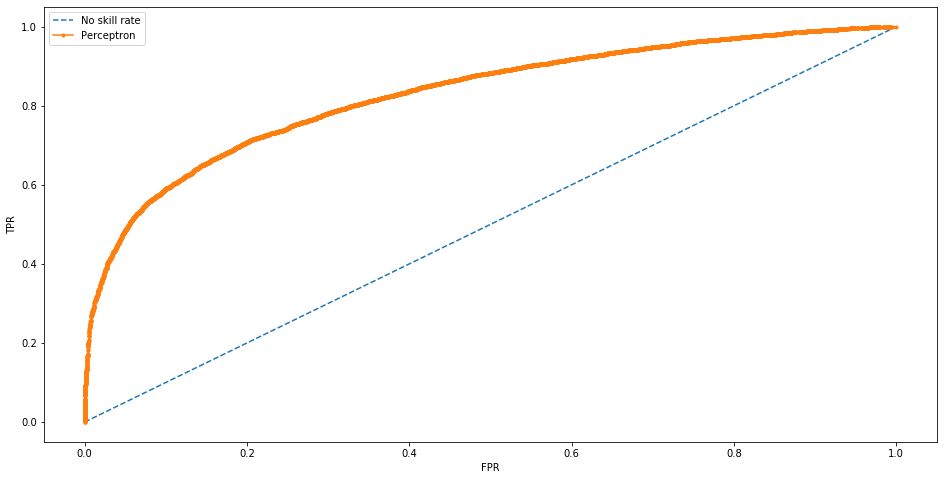

In [237]:
plot_ann_auc(perc,X_tests.values,y_tests.values,model_name='Perceptron')

In [238]:
perc_pred = perc.predict_classes(X_tests.values).flatten()
print(classification_report(y_tests,perc_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.48      0.52      4889
         1.0       0.86      0.89      0.87     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.68      0.69     21757
weighted avg       0.79      0.80      0.79     21757



# Additional Layers and Dropout Regularization

As can be seen in the perceptron network, the network appears to be overfitting to the train dataset, returning an AUC and accuracy that's higher than it is on our test data. Though the performance on the minority class is better on the test data, we can see that the AUC is still lower than the train data and lower than the Random Forest performance. To avoid this overfitting we can attempt to include some more layers to include more weight and bias values to update and include dropout layers to help the model parse out co-evolutionary nodes.

In [241]:
ann = Sequential()
ann.add(Dense(112,
              input_dim=112,
              activation='relu',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))
ann.add(Dense(224,
              input_dim=112,
              activation='relu',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))
ann.add(Dropout(0.5,seed=42))
ann.add(Dense(112,
              input_dim=112,
              activation='relu',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))
ann.add(Dense(224,
              input_dim=112,
              activation='relu',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))
ann.add(Dropout(0.5,seed=42))
ann.add(Dense(112,
              input_dim=112,
              activation='relu',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))
ann.add(Dense(1,
              input_dim=112,
              activation='sigmoid',
              kernel_initializer=initializers.glorot_uniform(seed=42),
              bias_initializer='zeros'))

In [242]:
ann.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['accuracy',auc])
ann.fit(X_trains.values,y_trains.values,epochs=100,callbacks=[earlystop_callback])

Train on 50766 samples
Epoch 1/100
50766/50766 [==============================] - 5s 101us/sample - loss: 0.4410 - accuracy: 0.7893 - auc_9: 0.7813
Epoch 2/100
50766/50766 [==============================] - 4s 71us/sample - loss: 0.4180 - accuracy: 0.8009 - auc_9: 0.8108
Epoch 3/100
50766/50766 [==============================] - 4s 70us/sample - loss: 0.4115 - accuracy: 0.8044 - auc_9: 0.8189
Epoch 4/100
50766/50766 [==============================] - 4s 69us/sample - loss: 0.4072 - accuracy: 0.8057 - auc_9: 0.8232
Epoch 5/100
50766/50766 [==============================] - 4s 70us/sample - loss: 0.4050 - accuracy: 0.8050 - auc_9: 0.8258
Epoch 6/100
50766/50766 [==============================] - 4s 70us/sample - loss: 0.4010 - accuracy: 0.8074 - auc_9: 0.8297
Epoch 7/100
50766/50766 [==============================] - 4s 70us/sample - loss: 0.4002 - accuracy: 0.8059 - auc_9: 0.8307
Epoch 8/100
50766/50766 [==============================] - 4s 71us/sample - loss: 0.3978 - accuracy: 0.8077 

# Neural Network Performance

With a slight increase in AUC from the perceptron model, we can see that including dropout layers slightly increases AUC. However, we've improved overall model performance at the cost of some small amount of minority class performance. It's important to remember that these models both have their slight advantages and disadvantages depending on the use case, however they perform virtually the same even with dropout regularization applied.

No Skill Rate AUC:  0.5
Learned AUC:  0.8320995728118947


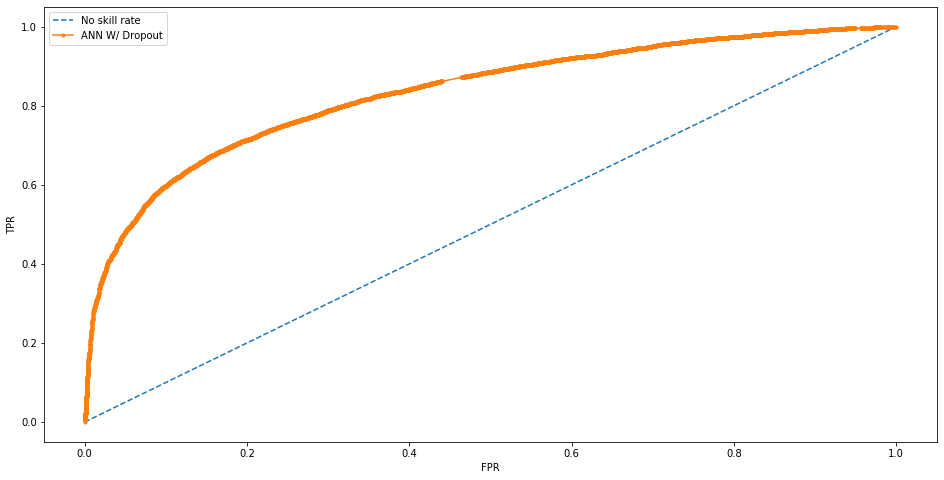

In [243]:
plot_ann_auc(ann,X_tests.values,y_tests.values,model_name='ANN W/ Dropout')

In [244]:
ann_pred = ann.predict_classes(X_tests.values).flatten()
print(classification_report(y_tests,ann_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.37      0.45      4889
         1.0       0.84      0.93      0.88     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.65      0.67     21757
weighted avg       0.78      0.80      0.78     21757



In [245]:
print("Perceptron:\n",classification_report(y_tests,perc_pred),"ANN W/ Dropout Regularization:\n",classification_report(y_tests,ann_pred))

Perceptron:
               precision    recall  f1-score   support

         0.0       0.56      0.48      0.52      4889
         1.0       0.86      0.89      0.87     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.68      0.69     21757
weighted avg       0.79      0.80      0.79     21757
 ANN W/ Dropout Regularization:
               precision    recall  f1-score   support

         0.0       0.59      0.37      0.45      4889
         1.0       0.84      0.93      0.88     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.65      0.67     21757
weighted avg       0.78      0.80      0.78     21757



# Conclusion and Domain Discussion

Random Forest performed better overall on the dataset, though the neural networks performed well also. We can see below the comparison of each models performance.

In [247]:
print("Random Forest:\n",classification_report(y_test,rf_pred),"\nPerceptron:\n",classification_report(y_tests,perc_pred),"\nANN W/ Dropout Regularization:\n",classification_report(y_tests,ann_pred))

Random Forest:
               precision    recall  f1-score   support

         0.0       0.70      0.45      0.55      4892
         1.0       0.86      0.94      0.90     16867

    accuracy                           0.83     21759
   macro avg       0.78      0.70      0.72     21759
weighted avg       0.82      0.83      0.82     21759
 
Perceptron:
               precision    recall  f1-score   support

         0.0       0.56      0.48      0.52      4889
         1.0       0.86      0.89      0.87     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.68      0.69     21757
weighted avg       0.79      0.80      0.79     21757
 
ANN W/ Dropout Regularization:
               precision    recall  f1-score   support

         0.0       0.59      0.37      0.45      4889
         1.0       0.84      0.93      0.88     16868

    accuracy                           0.80     21757
   macro avg       0.71      0.65      0.67     21757
weighted av

In [177]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)
features = X_trains.columns

## Benefit of Random Forest Interpretability

As mentioned earlier, a nice bonus to the Random Forest is the fact that we can see which features yield the highest information gain and see which features are most important. We can see the feature importance in descending order in the graph below, and surprisingly, it appears that the quality of grid infrastructure and the prevalence of economic incentives are less important to make a prediction of solar adoption. Additionally, the features that seem to be most important infer that there is a mix of importance primarily revolving around regional education, incomes and weather.

Text(0.5, 0, 'Relative Importance')

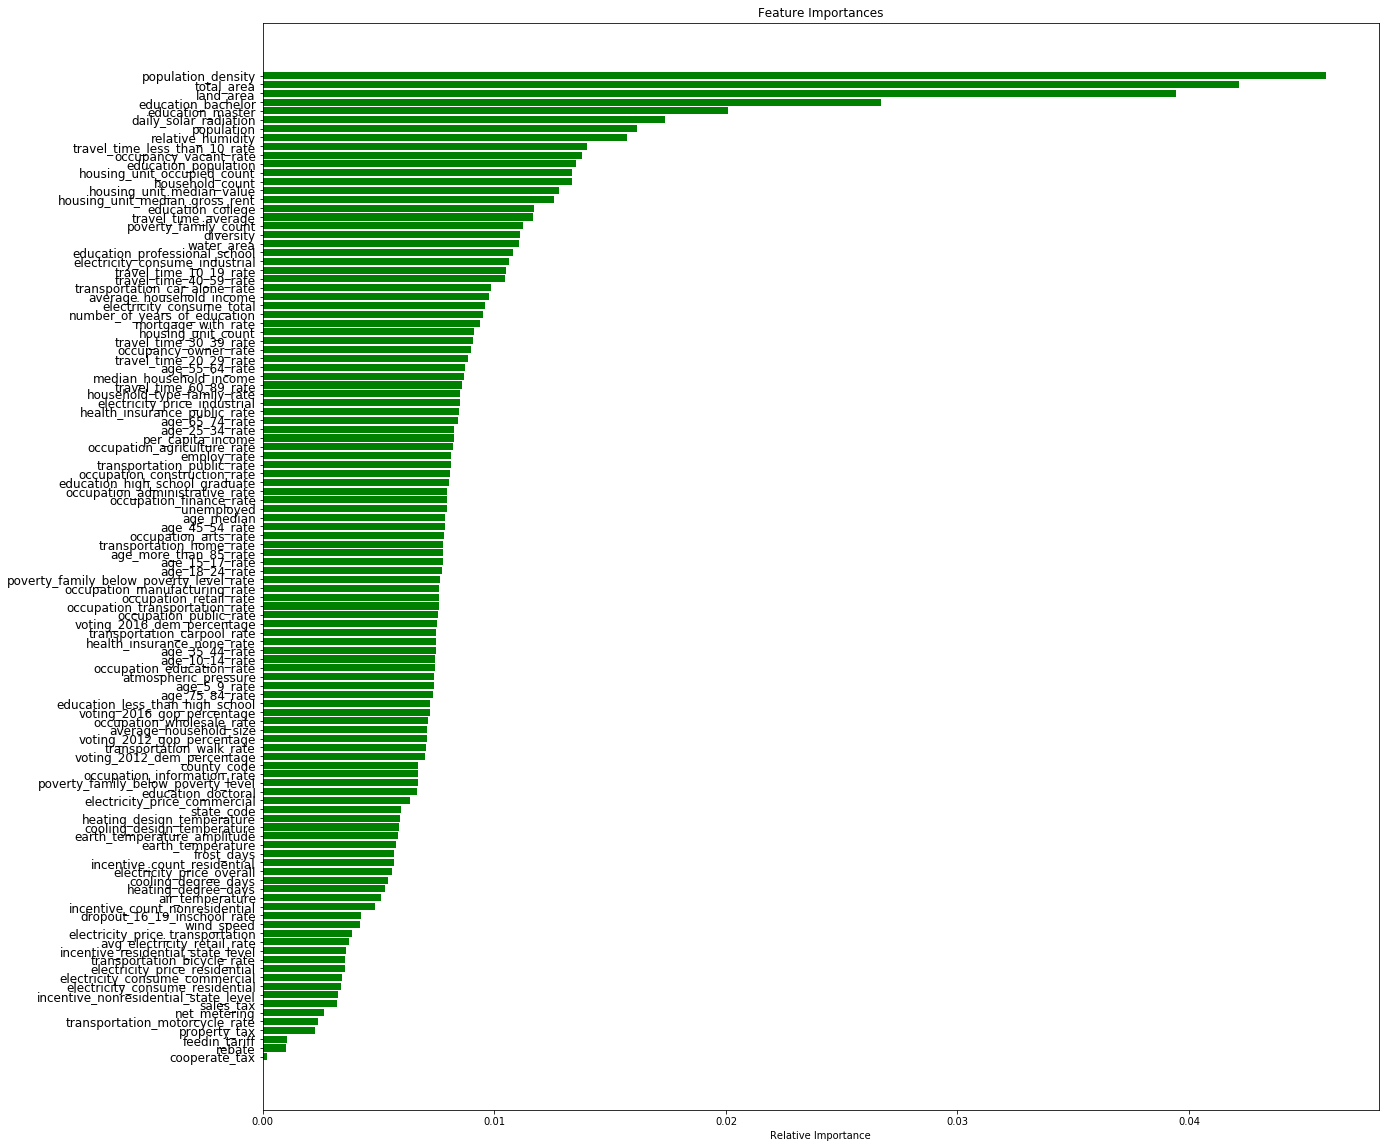

In [183]:
plt.figure(figsize=(20,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices],fontsize=12)
plt.xlabel('Relative Importance')